In [5]:
### This note book use nearest neighbor method(The most closest cell line) to predict CERES score of each gene. 
# Author: Yiyun

import pandas as pd
import os
from scipy.spatial import distance
import pickle
from scipy.stats import pearsonr

***
### Nearest Neighbor Model

In [82]:
### Read data
celligner_dir = '../data/DepMap/celligner'
q3_dir = '../data/DepMap/19Q3'
dir_div = '../out/20.0216 feat/reg_rf_boruta'

# Read celligner and 19q3 file(q3 is the actual data)
df_celligner = pd.read_csv(os.path.join(celligner_dir,'celligner_alignment.csv'),index_col = 0)
df_ref19q3 = pd.read_csv(os.path.join(q3_dir,'Achilles_gene_effect.csv'), index_col = 0)
# Get most diversed gene list
f_featsumm = os.path.join(dir_div,'anlyz_filtered','agg_summary_filtered.csv')
df_aggRes = pd.read_csv(f_featsumm) #aggregated feat summary
div_genes = df_aggRes['target'].to_list()

In [83]:
### Initialize output folder
out_dir = '../out/21.0406 nearest_neighbor'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [84]:
### Not all 19q3 cell lines are in celligner, we therefore filter the data in Celligner
#Therefore the closest cell line is not necessarily the one in the Celligner

# Extract the cell line data from celligner
df_celligner = df_celligner[df_celligner['sampleID'].str.startswith('ACH-')][['sampleID','UMAP_1','UMAP_2']].transpose()
header = df_celligner.iloc[0] 
df_celligner = df_celligner[1:] 
df_celligner.columns = header 
cell_q3cl = list(set(df_celligner.columns).intersection(set(df_ref19q3.index)))

# Select q3 cell line in celligner
df_celligner = df_celligner[cell_q3cl]

In [85]:
### Calculate euclidean distance between cell lines and find the closest pairs
df_close_cells = pd.DataFrame(index = ['closest_cell_line','distance'])
for cells in cell_q3cl:
    rest_cells = df_celligner.columns.drop(cells)
    dist_0 = float(10000) # initiate a biggest value to find the smallest value
    close_cell = 'Random'
    for rest_cell in rest_cells:
        dist = distance.euclidean(df_celligner[cells],df_celligner[rest_cell])
        # Update the smallest distance
        if dist <= dist_0:
            dist_0=dist
            close_cell = rest_cell
            
    df_close_cells[cells] = [close_cell,dist_0]

In [86]:
### Create actual dataframe
# Rename columns, exclude gene code after gene name
cols = [genes.split(' ')[0] for genes in df_ref19q3.columns]
df_ref19q3.columns = cols
# Create actual dataframe with column(most diversed genes) and index(cell lines)
df_actual = df_ref19q3.loc[cell_q3cl,div_genes]

In [88]:
### Fill the predicted dataframe by the value of the closest cell line
df_predicted = pd.DataFrame(index = cell_q3cl, columns = div_genes)
# Update the CERES score with the score of closest cell line
for cells in cell_q3cl:
    cls_cell = df_close_cells.loc['closest_cell_line',cells]
    df_predicted.loc[cells,:] = df_actual.loc[cls_cell,:]

In [103]:
# Save actual and predicted file
y_compr = {'actual':df_actual, 'predicted':df_predicted}

closest_cell_line    ACH-000901
distance              0.0795619
Name: ACH-000921, dtype: object

In [131]:
###Save actual and predicted model
# pickle.dump(df_close_cells, open(join(out_dir,'closest_cell_lines.pkl'),'wb'))
# pickle.dump(df_actual, open(join(out_dir,'actual.pkl'),'wb'))
# pickle.dump(df_predicted, open(join(out_dir,'predicted.pkl'),'wb'))
# pickle.dump(y_compr, open(join(out_dir,'y_compr.pkl'),'wb'))

***
### Calculate pearson correlation for figure

In [7]:
### Next, We calculate the Boruta model correlation coefficient
#-----------------------------Functions--------------------------------------------
### For reg_boruta, create y_compr_tr and te from individual model_perf file
def create_compr(boruta_dir):
    df_te_actual = pd.DataFrame();df_te_pred = pd.DataFrame()

    for f in os.listdir(boruta_dir):
        if f.startswith('y_compr_'): 
            gene = f.split('.')[0].split('_')[-1]
            y_compr_gene = pickle.load(open(os.path.join(boruta_dir,f),'rb'))
            df_te_actual[gene] = y_compr_gene['te']['y_actual']
            df_te_pred[gene] = y_compr_gene['te']['y_pred']

    y_compr_te_boruta = {'actual':df_te_actual,'predicted':df_te_pred}
    
    return y_compr_te_boruta

### Define a function calculate pearson correlation for all genes
def get_pearsonr(col):
    global y_compr
    
    name = col.name
    try:
        corr = pearsonr(col,y_compr['predicted'][name])[0]
    except ValueError:
        corr = float('NaN')
        
    return corr
#-----------------------------Functions--------------------------------------------

In [9]:
### Pearson Correlation calculation 
# Open the compr folder
model_dirs = {'rf_boruta': '../out/20.0819 modcompr/reg_rf_boruta',
              'nn':'../out/21.0406 nearest_neighbor'}
xlab_dict = {'rf_boruta': 'random forest\niter select+boruta',
              'nn': 'nearest neighbors'} # xlabel dict mapping

scores_corr = pd.DataFrame()
# Iterate through moddir to obtain y_compr prediction data
for model, model_dir in model_dirs.items():
    if model == 'rf_boruta': # If boruta, we collect the individual files
        y_compr = create_compr(os.path.join(model_dir,'model_perf'))
    elif model == 'nn':
        y_compr = pickle.load(open(os.path.join(model_dir,'y_compr.pkl'),'rb'))
    # Calculate pearson correlation between actual and predicted
    ser_corr = y_compr['actual'].apply(lambda x: get_pearsonr(x))
    scores_corr[model] = [ser_corr.median()]

   rf_boruta
0   0.641432
   rf_boruta       nn
0   0.641432  0.14816


In [18]:
print(f'The median pearson correlation coefficient for rf_boruta model is {scores_corr["rf_boruta"].values[0]}')
print(f'The median pearson correlation coefficient for nearest neighbor model is {scores_corr["nn"].values[0]}')

The median pearson correlation coefficient for rf_boruta model is 0.6414317721504253
The median pearson correlation coefficient for nearest neighbor model is 0.14815971505616796


In [150]:
# pickle.dump(scores_corr, open(join(out_dir,'scores_corr.pkl'),'wb'))

***
### For figure.py

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
import os

In [6]:
# settings
plt.interactive(False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def set_snsfont(s):
    sns.set(font_scale=s)
    sns.set_style("white")
set_snsfont(1.5)

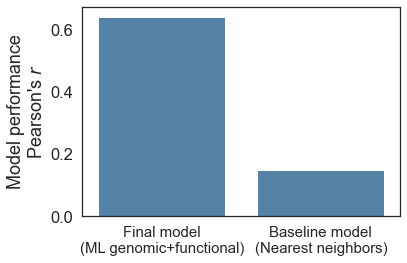

In [20]:
model_dirs = {'rf_boruta': '../out/20.0819 modcompr/reg_rf_boruta',
              'nn':'../out/21.0406 nearest_neighbor'}
xlab_dict = {'rf_boruta': 'Final model\n(ML genomic+functional)',
              'nn': 'Baseline model\n(Nearest neighbors)'} # xlabel dict mapping

scores_corr = pickle.load(open(os.path.join(model_dirs['nn'],'scores_corr.pkl'), 'rb'))

plt.figure()
ax = sns.barplot(scores_corr.columns, scores_corr.values[0], color='steelblue')
ax.set(ylabel="Model performance\nPearson's $\it{r}$", xlabel='', title='')
ax.set_xticklabels([xlab_dict[n] for n in model_dirs.keys()], rotation=0, size=15)
plt.tight_layout()
# plt.savefig("%s/fig1_boruta_nn.pdf" % dir_out)
# plt.close()